CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Check for MPS (Metal Performance Shaders) availability on Apple Silicon
mps_available = torch.backends.mps.is_available()
print(f"MPS Available: {mps_available}")

# Check if MPS is built (compiled with MPS support)
mps_built = torch.backends.mps.is_built()
print(f"MPS Built: {mps_built}")

# Set device based on availability
if mps_available and mps_built:
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Selected device: {device}")

# Test MPS with a simple tensor operation
if device.type == "mps":
    try:
        # Create a simple tensor on MPS
        test_tensor = torch.randn(3, 3, device=device)
        result = test_tensor @ test_tensor.T
        print("✅ MPS test successful!")
        print(f"Test tensor shape: {test_tensor.shape}")
        print(f"Result tensor shape: {result.shape}")
    except Exception as e:
        print(f"❌ MPS test failed: {e}")
        print("Falling back to CPU")
        device = torch.device("cpu")


MPS Available: True
MPS Built: True
Using MPS (Apple Silicon GPU)
Selected device: mps
✅ MPS test successful!
Test tensor shape: torch.Size([3, 3])
Result tensor shape: torch.Size([3, 3])


CODE BLOCK: 2

In [3]:
# CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)

CODE BLOCK: 3

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

CODE BLOCK: 5

In [6]:
print(f"Train Data shape: {train_data.targets.shape}, Test Data shape:  {test_data.targets.shape}")

Train Data shape: torch.Size([60000]), Test Data shape:  torch.Size([10000])


In [7]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [8]:
print(f"Train Loader Data Shape: {train_loader.dataset.targets.shape}, Test Loader Data Shape:  {test_loader.dataset.targets.shape}")

Train Loader Data Shape: torch.Size([60000]), Test Loader Data Shape:  torch.Size([10000])


CODE BLOCK: 6

/Users/pankajkumar/Documents/git/TSAI/ERA4/S4/mnist-training-epo1/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


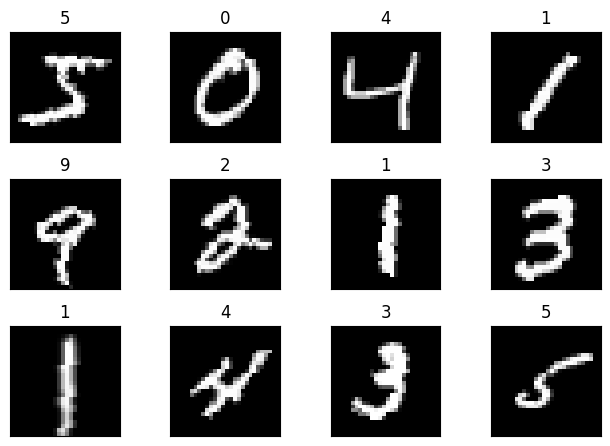

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [10]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(256*4*4, 50) # 16000
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        x = x.view(-1, 256*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



CODE BLOCK: 8

In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [12]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [13]:
from tabnanny import verbose


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# New Line
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_criterion)
  test(model, device, train_loader, test_criterion)
  scheduler.step()

Epoch 1


Train: Loss=1.1249 Batch_id=117 Accuracy=33.51: 100%|██████████| 118/118 [00:03<00:00, 34.62it/s]


Test set: Average loss: 1.4420, Accuracy: 39985/60000 (66.64%)

Epoch 2


Train: Loss=0.3299 Batch_id=117 Accuracy=88.55: 100%|██████████| 118/118 [00:03<00:00, 36.84it/s]


Test set: Average loss: 0.2005, Accuracy: 56155/60000 (93.59%)

Epoch 3


Train: Loss=0.2469 Batch_id=117 Accuracy=94.89: 100%|██████████| 118/118 [00:03<00:00, 37.08it/s]


Test set: Average loss: 0.1300, Accuracy: 57527/60000 (95.88%)

Epoch 4


Train: Loss=0.2673 Batch_id=117 Accuracy=96.36: 100%|██████████| 118/118 [00:03<00:00, 37.07it/s]


Test set: Average loss: 0.1030, Accuracy: 58086/60000 (96.81%)

Epoch 5


Train: Loss=0.1804 Batch_id=117 Accuracy=97.01: 100%|██████████| 118/118 [00:03<00:00, 37.08it/s]


Test set: Average loss: 0.0927, Accuracy: 58319/60000 (97.20%)

Epoch 6


Train: Loss=0.1882 Batch_id=117 Accuracy=97.45: 100%|██████████| 118/118 [00:03<00:00, 36.01it/s]


Test set: Average loss: 0.0865, Accuracy: 58410/60000 (97.35%)

Epoch 7


Train: Loss=0.1668 Batch_id=117 Accuracy=97.75: 100%|██████████| 118/118 [00:03<00:00, 37.02it/s]


Test set: Average loss: 0.0726, Accuracy: 58636/60000 (97.73%)

Epoch 8


Train: Loss=0.1494 Batch_id=117 Accuracy=97.97: 100%|██████████| 118/118 [00:03<00:00, 36.21it/s]


Test set: Average loss: 0.0703, Accuracy: 58668/60000 (97.78%)

Epoch 9


Train: Loss=0.1688 Batch_id=117 Accuracy=98.11: 100%|██████████| 118/118 [00:03<00:00, 36.94it/s]


Test set: Average loss: 0.0747, Accuracy: 58548/60000 (97.58%)

Epoch 10


Train: Loss=0.1154 Batch_id=117 Accuracy=98.22: 100%|██████████| 118/118 [00:03<00:00, 35.83it/s]


Test set: Average loss: 0.0570, Accuracy: 58938/60000 (98.23%)

Epoch 11


Train: Loss=0.1239 Batch_id=117 Accuracy=98.35: 100%|██████████| 118/118 [00:03<00:00, 35.79it/s]


Test set: Average loss: 0.0500, Accuracy: 59051/60000 (98.42%)

Epoch 12


Train: Loss=0.1434 Batch_id=117 Accuracy=98.40: 100%|██████████| 118/118 [00:03<00:00, 36.37it/s]


Test set: Average loss: 0.0438, Accuracy: 59171/60000 (98.62%)

Epoch 13


Train: Loss=0.1048 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:03<00:00, 37.18it/s]


Test set: Average loss: 0.0443, Accuracy: 59185/60000 (98.64%)

Epoch 14


Train: Loss=0.1187 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:03<00:00, 36.78it/s]


Test set: Average loss: 0.0409, Accuracy: 59235/60000 (98.72%)

Epoch 15


Train: Loss=0.0992 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:03<00:00, 36.36it/s]


Test set: Average loss: 0.0411, Accuracy: 59247/60000 (98.75%)

Epoch 16


Train: Loss=0.0813 Batch_id=117 Accuracy=98.95: 100%|██████████| 118/118 [00:03<00:00, 36.66it/s]


Test set: Average loss: 0.0332, Accuracy: 59380/60000 (98.97%)

Epoch 17


Train: Loss=0.0833 Batch_id=117 Accuracy=99.03: 100%|██████████| 118/118 [00:03<00:00, 37.08it/s]


Test set: Average loss: 0.0299, Accuracy: 59465/60000 (99.11%)

Epoch 18


Train: Loss=0.0827 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:03<00:00, 36.93it/s]


Test set: Average loss: 0.0298, Accuracy: 59457/60000 (99.09%)

Epoch 19


Train: Loss=0.1166 Batch_id=117 Accuracy=99.03: 100%|██████████| 118/118 [00:03<00:00, 36.50it/s]


Test set: Average loss: 0.0311, Accuracy: 59413/60000 (99.02%)

Epoch 20


Train: Loss=0.0653 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:03<00:00, 36.42it/s]


Test set: Average loss: 0.0291, Accuracy: 59461/60000 (99.10%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

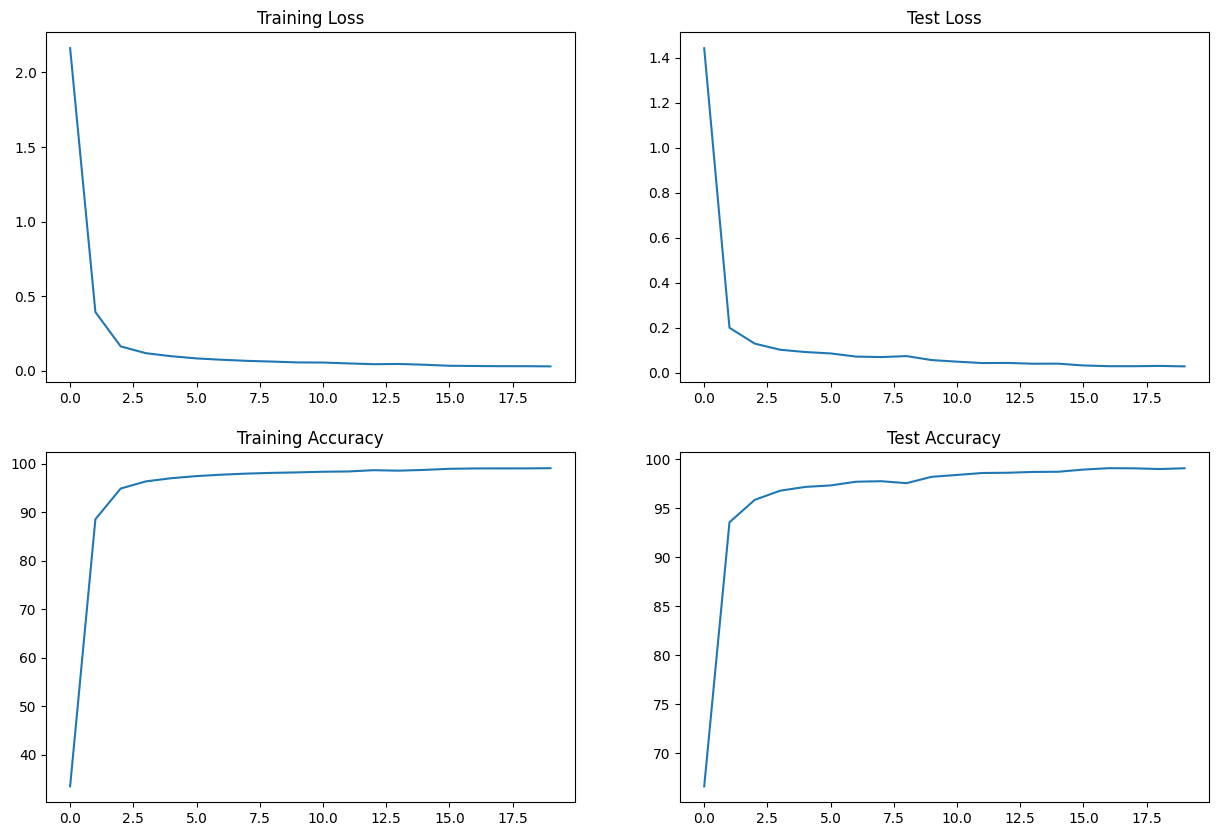

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [15]:
# # !pip install torchsummary
# from torchsummary import summary
# # use_cuda = torch.cuda.is_available()
# use_mps = torch.backends.mps.is_available()
# # device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("mps" if use_mps else "cpu")

In [16]:
from torchsummary import summary
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            295,168
├─Linear: 1-5                            204,850
├─Linear: 1-6                            510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            295,168
├─Linear: 1-5                            204,850
├─Linear: 1-6                            510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0